# Reverse Image Search - Deep Learning

Using [DeepFashion](http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html) dataset.

[Refer](https://www.oreilly.com/library/view/practical-deep-learning/9781492034858/ch04.html)

In [1]:
import tensorflow as tf
import numpy as np
from numpy.linalg import norm

import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, pathlib, time
import PIL
import PIL.Image


import pickle
from tqdm import tqdm, tqdm_notebook
# from ipywidgets import IntProgress

import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.5.0


In [3]:
# Check for available GPU-
gpu = tf.config.list_physical_devices('GPU')

if len(gpu) == 0:
    print(f"There are no available GPU")
else:
    print(f"Available GPU: {gpu}")

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.getcwd()

'/content'

In [ ]:
# Copy zipped image file from Google Drive to Colab directory-
!unzip "/content/drive/MyDrive/img.zip" -d "/content/"

## ResNet-50 CNN architecture:

- Load ResNet-50 model without the top classification layers, so we get only the bottleneck features.

- Then define a function that takes an image path, loads the image, resizes it to proper dimensions supported by ResNet-50, extracts the features, and then normalizes them.

In [ ]:
model = ResNet50(
    weights = 'imagenet', include_top = False,
    input_shape = (224, 224, 3)
)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features


In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
img_path = "/content/img/Zippered_Tartan_Plaid_Flannel/"

In [ ]:
features = extract_features(img_path = img_path + 'img_00000055.jpg', model = model)

# Note: ouput from last 'conv5_block3_out' = (None, 7, 7, 2048)
# 7 * 7 * 2048 = 100352

In [ ]:
type(features), features.shape

(numpy.ndarray, (100352,))

In [ ]:
print(len(features))

100352


The ResNet-50 model generated 2,048 features of shape (7, 7) from the provided image. Each feature is a floating-point value between 0 and 1.

If your model is trained or fine tuned on a dataset that is not similar to ImageNet, redefine the ```preprocess_input(img)``` step accordingly. The mean values used in the function are particular to the ImageNet dataset. Each model in Keras has its own preprocessing function so make sure you are using the right one.


## InceptionV3

[Refer](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3)

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [ ]:
model_inceptionv3 = tf.keras.applications.inception_v3.InceptionV3(
    include_top = False, weights = 'imagenet',
    input_shape = (224, 224, 3), pooling = 'avg',  # or 'max'
    # classifier_activation='softmax'
)


In [ ]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(
        img_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model_inceptionv3.predict(preprocessed_img)
    # features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features


In [ ]:
model_inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

### NOTE:

Applying ```avg pooling``` reduces output volume from (None, 5, 5, 2048) down to
(None, 2048)!

In [ ]:
features = extract_features(img_path = img_path + 'img_00000055.jpg', model = model_inceptionv3)

In [ ]:
type(features), features.shape

(numpy.ndarray, (2048,))

In [ ]:
print(len(features))

2048


In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
                
    return file_list
    

In [ ]:
path_to_img = "/content/img/"

In [ ]:
# provide path to our dataset and call the function-

# path to the datasets-
root_dir = path_to_img
filenames = sorted(get_file_list(root_dir))

In [ ]:
type(filenames), len(filenames)

(list, 289229)

In [ ]:
# Sanity check-
filenames[1]

'/content/img/1981_Graphic_Ringer_Tee/img_00000002.jpg'

Define a variable that will store all of the features, go through all filenames in the dataset, extract their features, and append them to the previously defined variable-

In [ ]:
feature_list = []

# for i in range(len(filenames)):
for i in tqdm_notebook(range(len(filenames))):
    # print(f"Current file being processed = {i + 1}")
    feature_list.append(extract_features(filenames[i], model_inceptionv3))
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
len(feature_list), len(filenames)

(289229, 289229)

In [ ]:
# Finally, write these features to a pickle file so that we can use them in the future without having to recalculate them-
'''
pickle.dum(feature_list, open('DeepFashion_features_resnet50.pickle', 'wb'))
pickle.dump(filenames, open('DeepFashion_filenames_resnet50.pickle', 'wb'))
'''

In [ ]:
# Finally, write these features to a pickle file so that we can use them in the future without having to recalculate them-

pickle.dump(feature_list, open('DeepFashion_features_inceptionnetv3.pickle', 'wb'))
pickle.dump(filenames, open('DeepFashion_filenames_inceptionnetv3.pickle', 'wb'))

In [ ]:
# Copy extracted features to Google Drive-
!cp DeepFashion_features_inceptionnetv3.pickle /content/drive/MyDrive/

In [5]:
# !cp /content/drive/MyDrive/DeepFashion_features_inceptionnetv3.pickle /content/

In [ ]:
print("Finished!")

Finished!


In [ ]:
feature_list[0].shape

(2048,)

## Similarity Search:

Given a photograph, our aim is to find another photo in our dataset similar to the current one.

In [ ]:
'''
# We begin by loading the precomputed features-
filenames = pickle.load(open('DeepFashion_filenames_resnet50.pickle', 'rb'))
feature_list = pickle.load(open('DeepFashion_features_resnet50.pickle', 'rb''))
'''

In [ ]:
feature_list = pickle.load(open('DeepFashion_features_inceptionnetv3.pickle', 'rb'))
filenames = pickle.load(open('DeepFashion_filenames_inceptionnetv3.pickle', 'rb'))

- Use ```scikit-learn``` for finding nearest neighbors of the query features; that is, features that represent a query image.
- We train a nearest-neighbor model using the brute-force algorithm to find the nearest __k__ (k = 5) neighbors based on Euclidean distance or some other metric.


In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neighbors = NearestNeighbors(
    n_neighbors = 5, algorithm ='brute',
    metric = 'minkowski').fit(feature_list)

In [ ]:
distances, indices = neighbors.kneighbors([feature_list[0]])

In [ ]:
type(distances), distances.shape, indices.shape

(numpy.ndarray, (1, 5), (1, 5))

Now you have both the indices and distances of the nearest five neighbors of the very first query feature (which represents the first image). Notice the quick execution of the first step—the training step. Unlike training most machine learning models, which can take from several minutes to hours on large datasets, instantiating the nearest-neighbor model is instantaneous because at training time there isn’t much processing. This is also called lazy learning because all the processing is deferred to classification or inference time.

Now that we know the indices, let’s see the actual image behind that feature. First, we pick an image to query, located at say, index = 0:

## Visualize __Reverse Image Search__ in action:

In [ ]:
import matplotlib.image as mpimg
%matplotlib inline

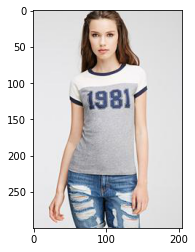

In [ ]:
# VIsualize image for which image search is to be done-
plt.imshow(mpimg.imread(filenames[0]))

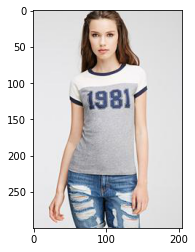

In [ ]:
# Examine the nearest neighbors by plotting the first result-
plt.imshow(mpimg.imread(filenames[indices[0][0]]))

Wait, isn’t that a duplicate? Actually, the nearest index will be the image itself because that is what is being queried-

In [ ]:
for i in range(5):
    print(distances[0][i])

4.712161e-08
0.13729234
0.48309827
0.51325256
0.5149175


This is also confirmed by the fact that the distance of the first result is zero. Now let’s plot the real first nearest neighbor-

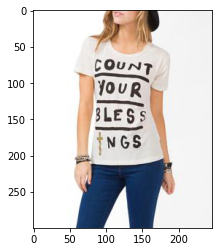

In [ ]:
# Plot other similar images-
plt.imshow(mpimg.imread(filenames[indices[0][2]]))

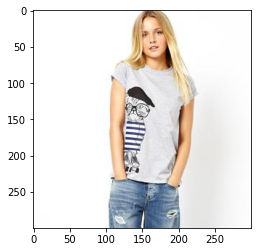

In [ ]:
plt.imshow(mpimg.imread(filenames[indices[0][3]]))

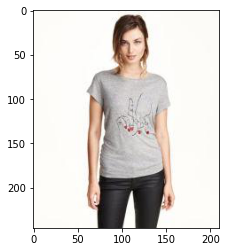

In [ ]:
plt.imshow(mpimg.imread(filenames[indices[0][4]]))

In [80]:
len(filenames)

289229

#### Take another example:

In [63]:
import random

In [164]:
random_image_index = random.randint(0, len(filenames))

In [165]:
distances, indices = neighbors.kneighbors([feature_list[random_image_index]])

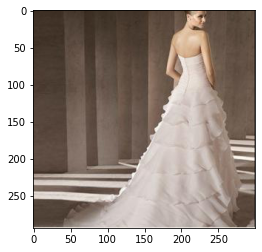

In [166]:
# Plot the original image for which reverse image search is to be performed-
plt.imshow(mpimg.imread(filenames[indices[0][0]]))

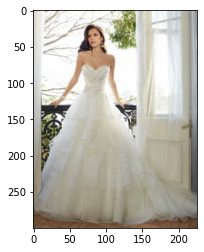

In [167]:
# Show other similar images-
plt.imshow(mpimg.imread(filenames[indices[0][2]]))

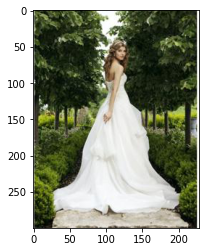

In [168]:
plt.imshow(mpimg.imread(filenames[indices[0][3]]))

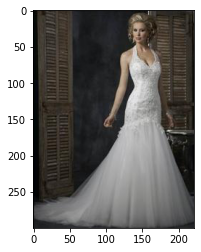

In [169]:
plt.imshow(mpimg.imread(filenames[indices[0][4]]))

### TSNE Dimensionality Reduction:

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
time_start = time.time()
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(feature_list)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 289229 samples in 230.171s...


In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x = "tsne-2d-one", y = "tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)